java-1.11.0-openjdk-amd64  java-11-openjdk-amd64  java-1.8.0-openjdk-amd64  java-8-openjdk-amd64
bin   data	jars	    LICENSE   NOTICE  R		 RELEASE  yarn
conf  examples	kubernetes  licenses  python  README.md  sbin
   C_CUSTKEY              C_NAME                       C_ADDRESS  C_NATIONKEY  \
0          1  Customer#000000001               IVhzIApeRb ot,c,E           15   
1          2  Customer#000000002  XSTf4,NCwDVaWNe6tEgvwfmRchLXak           13   
2          3  Customer#000000003                    MG9kdTD2WBHm            1   
3          4  Customer#000000004                     XxVSJsLAGtn            4   
4          5  Customer#000000005    KvpyuHCplrB84WgAiGV6sYpZq7Tj            3   

           C_PHONE  C_ACCTBAL C_MKTSEGMENT  \
0  25-989-741-2988     711.56     BUILDING   
1  23-768-687-3665     121.65   AUTOMOBILE   
2  11-719-748-3364    7498.12   AUTOMOBILE   
3  14-128-190-5944    2866.83    MACHINERY   
4  13-750-942-6364     794.47    HOUSEHOLD   

                      

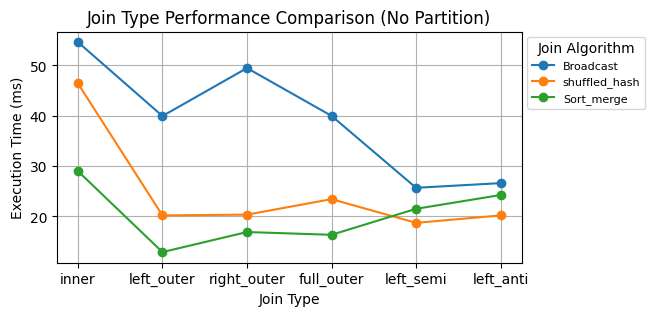

<function matplotlib.pyplot.close(fig=None)>

In [ ]:
# installing dependencies
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://dlcdn.apache.org/spark/spark-3.5.0/spark-3.5.0-bin-hadoop3.tgz
!tar xf spark-3.5.0-bin-hadoop3.tgz

!pip install -q findspark
!pip install pyspark
!ls /usr/lib/jvm/
!pip install -U pyarrow
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.0-bin-hadoop3"

!ls /content/spark-3.5.0-bin-hadoop3

# import necessary packages
import concurrent.futures
from pyspark.sql import SparkSession
from pyspark import SparkConf
import time
import pandas as pd
import matplotlib.pyplot as plt

# read the dataframe
df1 = pd.read_csv('/content/tpch_data/customer.csv')
print(df1.head())

df2 = pd.read_csv('/content/tpch_data/orders.csv')
print(df2.head())

# Drop column c_8 from table customer which is null
df1 = df1.drop('_c8', axis=1)
print(df1.head())
print(df1.info())

# Drop column c_9 from table orders: null values
df2 = df2.drop('_c9', axis=1)
print(df2.head())
print(df2.info())

# Define a Pandas DataFrame to store the results
join_types = ["inner", "left_outer", "right_outer", "full_outer", "left_semi", "left_anti"]
results_df = pd.DataFrame(columns=['Algorithm'] + join_types)

# Number of threads to use
num_threads = 3


# Set Spark configurations
conf = SparkConf() \
    .setAppName("example") \
    .setMaster("local[*]") \
    .set("spark.executor.memory", "2g") \
    .set("spark.driver.memory", "2g") \
    .set("spark.memory.fraction", "0.6")

# **************************************************************************
# Broadcast join
from pyspark.sql.functions import broadcast

# Create a Spark session
spark = SparkSession.builder.config(conf=conf).getOrCreate()

spark_df1 = spark.createDataFrame(df1)
spark_df2 = spark.createDataFrame(df2)

# Disable automatic partitioning by setting the number of partitions to 1
spark_df1 = spark_df1.repartition(1)
spark_df2 = spark_df2.repartition(1)


# Split the tasks into equal parts for parallel execution
tasks = [(spark_df1, spark_df2)] * num_threads

# Algorithm name
algorithm_name = 'Broadcast'

# Function to perform join for a specific join type
def perform_join(join_type):
    # Record the start time
    start_time = time.time()

    # Perform the join for the current join type
    broadcast_df1 = broadcast(spark_df1)

    result = broadcast_df1.join(spark_df2.hint("broadcast"), broadcast_df1["C_CUSTKEY"] == spark_df2["O_CUSTKEY"], join_type)

    # Record the end time
    end_time = time.time()

    # Calculate and print the time taken
    time_taken = (end_time - start_time) * 1000
    print(f"Time taken to perform {join_type} join: {time_taken:.2f} milliseconds")

    return join_type, time_taken


# Create a ThreadPoolExecutor
with concurrent.futures.ThreadPoolExecutor(max_workers=num_threads) as executor:
    for join_type in join_types:
      futures = executor.submit(perform_join, join_type)
      join_type, time_taken = futures.result()
      results_df.at[0, join_type] = round(time_taken, 2)


# Add the algorithm name to the results DataFrame
results_df.at[0, 'Algorithm'] = algorithm_name

# Display the results DataFrame
print("\nResults DataFrame:")
print(results_df)

# Stop the Spark session
spark.stop()


# *****************************************************************************
# shuffled_hash Join

# Create a Spark session
spark = SparkSession.builder.config(conf=conf).getOrCreate()
spark_df1 = spark.createDataFrame(df1)
spark_df2 = spark.createDataFrame(df2)

# Disable automatic partitioning by setting the number of partitions to 1
spark_df1 = spark_df1.repartition(1)
spark_df2 = spark_df2.repartition(1)


# Split the tasks into equal parts for parallel execution
tasks = [(spark_df1, spark_df2)] * num_threads

# Algorithm name
algorithm_name = 'shuffled_hash'

# Function to perform join for a specific join type
def perform_join(join_type):
    # Record the start time
    start_time = time.time()

    # Perform the join for the current join type
    result = spark_df1.join(spark_df2.hint("shuffled_hash"), spark_df1["C_CUSTKEY"] == spark_df2["O_CUSTKEY"], join_type)

    # Record the end time
    end_time = time.time()

    # Calculate and print the time taken
    time_taken = (end_time - start_time) * 1000
    print(f"Time taken to perform {join_type} join: {time_taken:.2f} milliseconds")

    return join_type, time_taken



# Create a ThreadPoolExecutor
with concurrent.futures.ThreadPoolExecutor(max_workers=num_threads) as executor:
    for join_type in join_types:
      futures = executor.submit(perform_join, join_type)
      join_type, time_taken = futures.result()
      results_df.at[1, join_type] = round(time_taken, 2)


# Add the algorithm name to the results DataFrame
results_df.at[1, 'Algorithm'] = algorithm_name

# Display the results DataFrame
print("\nResults DataFrame:")
print(results_df)

# Stop the Spark session
spark.stop()

# ****************************************************************************
#  Sort_merge Join

# Create a Spark session
spark = SparkSession.builder.config(conf=conf).getOrCreate()

spark_df1 = spark.createDataFrame(df1)
spark_df2 = spark.createDataFrame(df2)

# Disable automatic partitioning by setting the number of partitions to 1
spark_df1 = spark_df1.repartition(1)
spark_df2 = spark_df2.repartition(1)


# Split the tasks into equal parts for parallel execution
tasks = [(spark_df1, spark_df2)] * num_threads

# Algorithm name
algorithm_name = 'Sort_merge'

# Function to perform join for a specific join type
def perform_join(join_type):
    # Record the start time
    start_time = time.time()

    # Perform the join for the current join type
    result = spark_df1.join(spark_df2.hint("sort_merge"), spark_df1["C_CUSTKEY"] == spark_df2["O_CUSTKEY"], join_type)

    # Record the end time
    end_time = time.time()

    # Calculate and print the time taken
    time_taken = (end_time - start_time) * 1000
    print(f"Time taken to perform {join_type} join: {time_taken:.2f} milliseconds")

    return join_type, time_taken

# Create a ThreadPoolExecutor
with concurrent.futures.ThreadPoolExecutor(max_workers=num_threads) as executor:
    for join_type in join_types:
      futures = executor.submit(perform_join, join_type)
      join_type, time_taken = futures.result()
      results_df.at[2, join_type] = round(time_taken, 2)


# Add the algorithm name to the results DataFrame
results_df.at[2, 'Algorithm'] = algorithm_name

# Display the results DataFrame
print("\nResults DataFrame:")
print(results_df)

# Stop the Spark session
spark.stop()
# ****************************************************************************
results_df.to_csv('results_no_part_3Thread.csv')
# ****************************************************************************

# Plotting
plt.figure(figsize=(6, 3))

# Loop through join algorithms and plot lines
join_algorithms = results_df['Algorithm'].tolist()
for join_algorithm in join_algorithms:
    plt.plot(results_df.columns[1:], results_df[results_df['Algorithm'] == join_algorithm].iloc[0, 1:], marker='o', label=join_algorithm)

# Adding labels and title
plt.xlabel('Join Type')
plt.ylabel('Execution Time (ms)')
plt.title('Join Type Performance Comparison (No Partition)')
plt.legend(title='Join Algorithm', bbox_to_anchor=(1.0, 1), loc='upper left', fontsize= '8')
plt.grid(True)
plt.savefig('Join_Type_Performance_Comparison_noP_3Th.png')
plt.show()
plt.close